# Code to plot Dissolved Oxygen from BGC-Argo Float and HYCOM-ECOSMO model
### Here, masked argo oxygen flags and corresponding masked model oxygen were plotted to compare
#### CAUTION: This jupyter notebook is using external python scripts. So make sure they are in-place before running

## Load essentials 

In [1]:
import cmocean
from matplotlib.ticker import MaxNLocator
import pickle
from netCDF4 import Dataset as NetCDFFile
import xarray as xr
import matplotlib.dates as mdates
# import nclcmaps # this package cannot be installed in conda-jupyternotebook
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image
import subprocess
import sys


%run ../helper_functions/argoinput_helpers.py

# Processing Oxygen fields 

# Before proceed further make sure you have both argo profiling float data and colocated model 
### Each netcdf should represent a only one argo data based on its ID - ideally named - "GL_PR_PF_ArgoWMOID.nc". e.g; GL_PR_PF_2902118.nc
### similary the  colocated model data is named as "archm_argo_ArgoWMOID_merged_2014_2020.nc". e.g: archm_argo_2902118_merged_2014_2020.nc
### ideally both argo and colocated model netcdf files should be placed in the current directory

<======================================================================================================>
<------------------------------------------------------------------------------------------------------>
                           (1)       plotting 2902118
********************************************************************************************************
Plots will be saved in the  :  ../outputs/plots_model_vs_argo/
********************************************************************************************************
Evaluating Field : | DOX2 | from file :::>  /media/akashs/FA22E72622E6E69B/DATA1_disk/1_NANSEN/DATA_LIBRARY_LOCAL/BGC_ARGO/arabian_sea/GL_PR_PF_2902118.nc
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
since of ARGO 1950
ARGO 2902118 DOX2 minimum:  -1
ARGO 2902118 DOX2 maximum:  217
  
Non-Interpolated ARGO variable will be plotted (SCATTER PLOT)
----------------------------------------------------------------
START DATE a

Model ECO_oxy for ARGO  (defined in function) minimum :  0
Model ECO_oxy for ARGO  (defined in function) maximum :  207
START DATE and END DATE of ORIGINAL MODEL variable  2014-01-01T12:00:00.000000000 2020-12-30T12:00:00.000000000
  
Interpolated ARGO variable will be plotted (CONTOUR PLOT) 
----------------------------------------------------------------
NOTE: If interpolation not required: call contourdata() with ARGOinterpolation=False  
START DATE and END DATE of interpolated ARGO variable  2014-01-01 12:00:00 2020-12-30 12:00:00
  
Interpolated/Default MODEL variable will be plotted (CONTOUR PLOT)
------------------------------------------------------------------------
Model ECO_oxy for ARGO  (defined in function) minimum :  0
Model ECO_oxy for ARGO  (defined in function) maximum :  207
START DATE and END DATE of ORIGINAL MODEL variable  2014-01-01T12:00:00.000000000 2020-12-30T12:00:00.000000000
  
Interpolated ARGO variable will be plotted (CONTOUR PLOT) 
----------------------

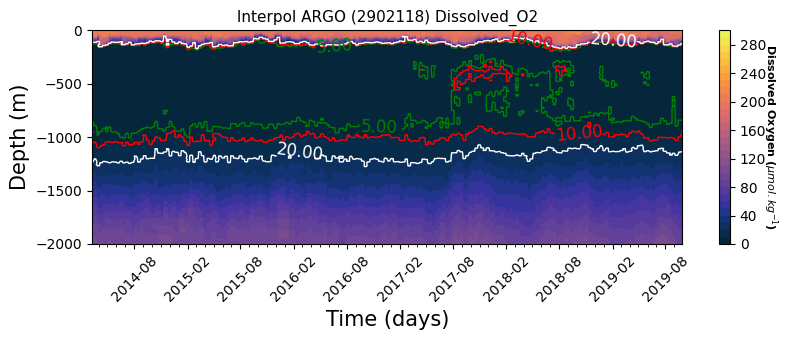

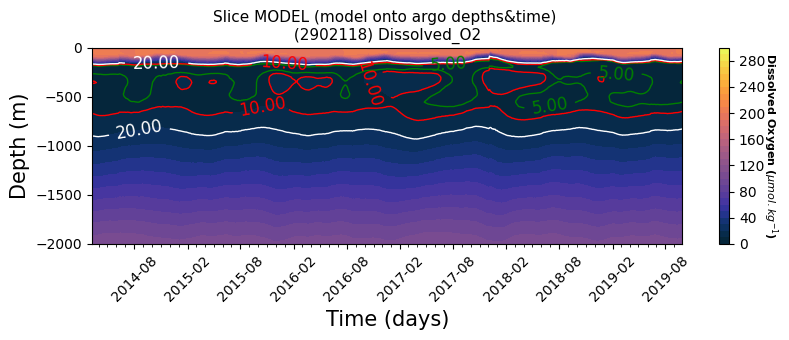

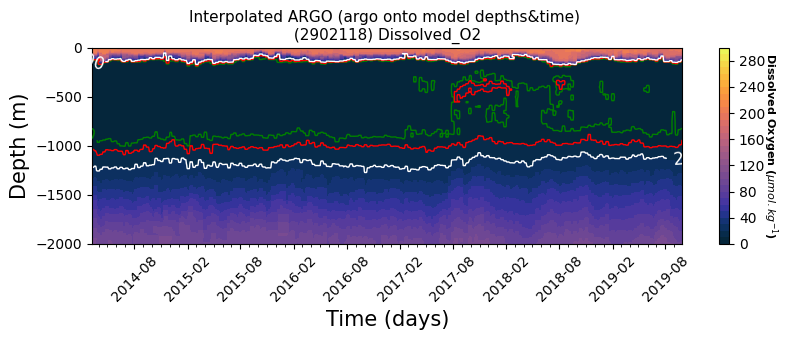

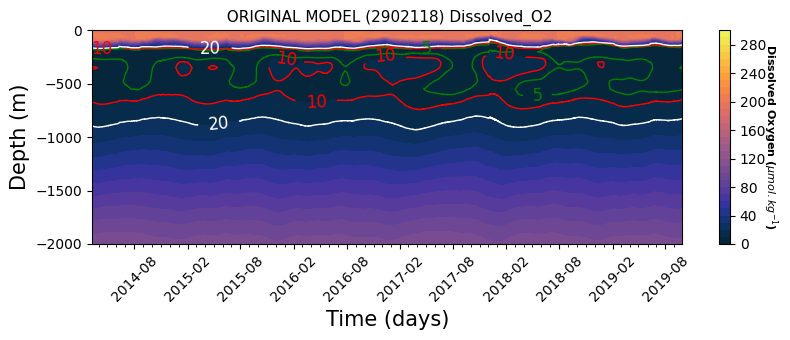

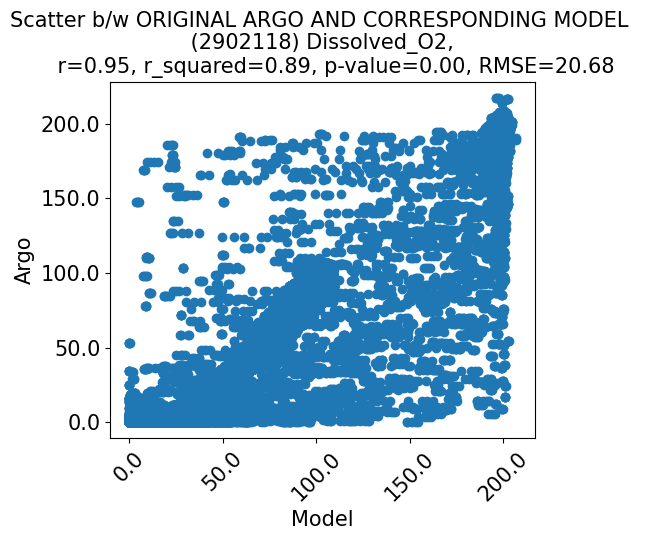

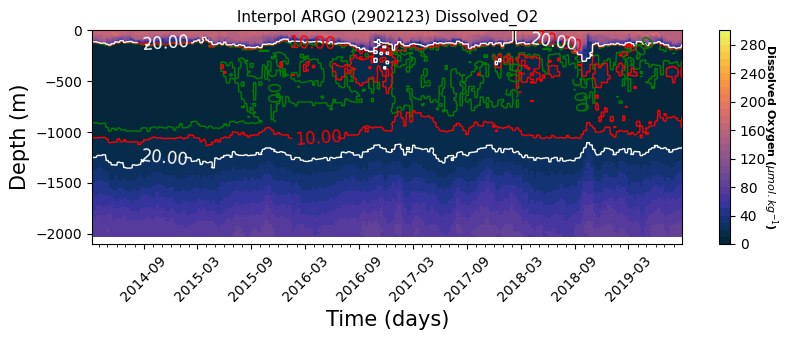

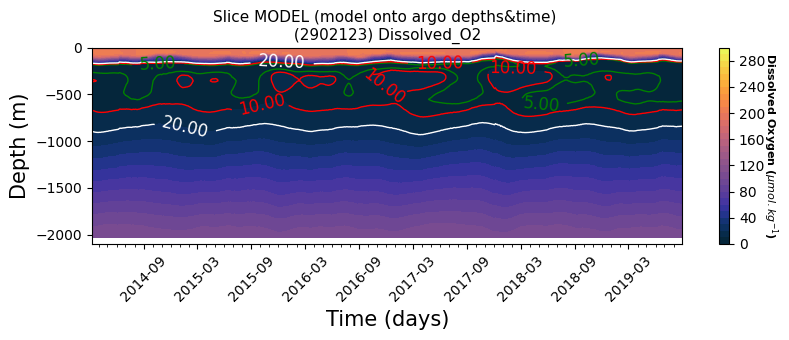

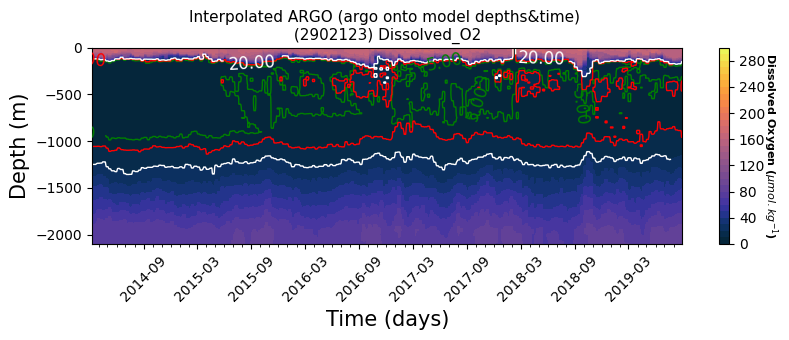

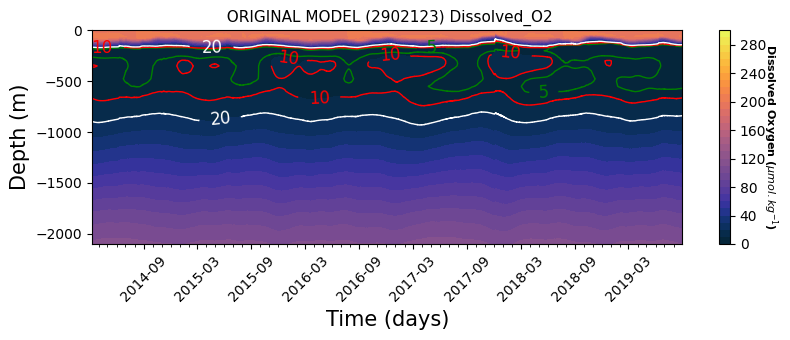

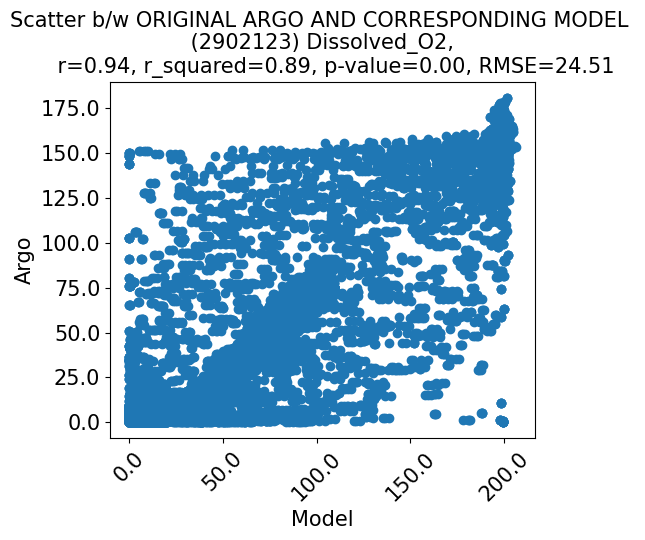

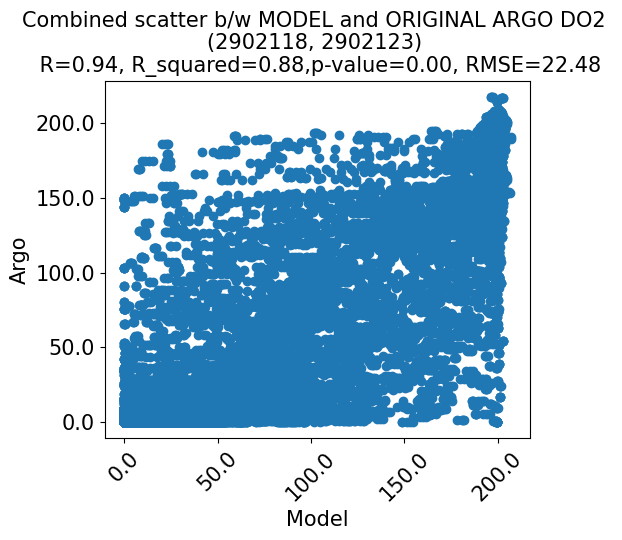

In [2]:
%%time

# List your argo float IDs (comma separated) eg; argo = ['2902118', '2902123']
argo = ['2902118', '2902123']

# Make a dictionary for desired depths for each float
dbot_dict = {
    '2902118': 2000,
    '2902123': 2100, 
}

plotdata = {
    '2902118':{'first':2014, 'last':2020},
    '2902123':{'first':2014, 'last':2019},
}

# initialize empty lists to store flattened arrays
model_flat_list_1 = []; argo_flat_list_1 = []; model_flat_list_2 = []; argo_flat_list_2 = []
all_items_list = []


for i, item in enumerate(plotdata):
#     print(f"({i+1}) plotting {item}")
    print('<======================================================================================================>')
    print('<------------------------------------------------------------------------------------------------------>')
    print(f'                           ({i+1})       plotting '+item                                                    )
    OUTdirectory = "../outputs/plots_model_vs_argo/"
    print('********************************************************************************************************')
    print('Plots will be saved in the  : ', OUTdirectory )
    print('********************************************************************************************************')
    #
###########################################################################################################
#
    currVar = 'oxy'  # Current varaible used for colorbar labelling inside contourdata() & cont() functions
#    
############################################################################################################
    # Load depth limit from dbot_dict
    dbot = dbot_dict[item]
###############################################################################################
## PLOT & PREPARE: RAW ARGO FLOATS (WITH FLAGS IF AVAILABLE)
###############################################################################################

    # LOAD ARGO FLOAT DATA (.nc file) AND DEFINE VARIABLES IN THE FUNCITON SCRIPT

    # Use readARGO() function to read the ARGO data - dissolved oxygen ( DOX2 )
    pres, since, time2d, dates, lon, lonint, lat, latint, timeint, oxy, oxyqc = \
    readARGO(int(item), 'DOX2', all=True,opendap=True)

    flag_oxy  = construct(oxy,oxyqc,[1,5,8])  # here I chose 1,5, and 8 quality flags. Check your data apply carefully 
    title_A = r' ORIGINAL ARGO ('+item+') Dissolved_O2 '
    
    dummy_ = pd.to_datetime(dates); dummy_ = dummy_.date
    Aoxy0,Adate0,Adep0,upper,lower,iur,ilr,label,unit = \
    contourdata(time2d,pres,flag_oxy,title_A,True,True,int(item),currVar,nlevels=30,ARGOinterpolation=False,\
                dbot=dbot,sinced=[since,1,1,0,0,0],minyear=dummy_[0],maxyear=dummy_[-1],\
                cmin=0,cmax=200,isoline=False)
    ppp = plt.gcf(); plt.close(ppp)  
    
    Adate0_conv = pd.to_datetime(Adate0); Adate0_conv = Adate0_conv.date    
    
##############################################################################################################
## PLOT & PREPARE: MODEL CORRESPONDS TO ORIGINAL ARGO FLOATS (WITH FLAGS IF AVAILABLE)
##                 Pls NOTE, here, model time and depths are exactly same as argo.
##                 Mask of flag_oxy is tried to apply on model
##############################################################################################################

    #directory = "/media/akashs/FA22E72622E6E69B/DATA1_disk/1_NANSEN/DATA_LIBRARY_LOCAL/HYCOM_ECOSMO/STATION_DATA/BGC_ARGO/"
    directory = './'
    pattern = directory + 'archm_argo_'+str(item)+'_merged_'+'*.nc' # this is already colocated model with argo
    for filename in glob.glob(pattern):
        nc = xr.open_dataset(filename)

    title_M = 'MODEL ('+item+')\nDissolved_O2 '

    Model_oxy0,Mdate0,Mdep0,upper,lower,iur,ilr,label,unit = \
    contourdata(0,0,0,title_M,True,True,int(item),currVar,nlevels=30,dbot=dbot,model=nc,
                variable='ECO_oxy',sinced=[since,1,1,0,0,0],minyear=Adate0_conv[0], \
                maxyear=Adate0_conv[-1],cmin=0,cmax=300,isoline=False)  
    # minyear=plotdata[item]['first'], maxyear=plotdata[item]['last']
    ppp = plt.gcf(); plt.close(ppp) # By uncommenting these lines, the plot will not display 

    Mdate0 = np.array(Mdate0)
    Mdep0 = np.array(Mdep0)
    Adate0 = np.array(Adate0)
    Adep0 = np.array(Adep0)

    # slice model onto argo time and depths
    Model_oxy0_interp, interp_depth, Model_oxy0_slice, Model_oxy0_slice_masked,Mdate0_sliced =\
    slice_model(dbot,Mdate0, Mdep0, Adate0, Adep0, Model_oxy0.T, flag_oxy)
    
#############################################################################################
## PLOT & PREPARE: INTERPOLATED ARGO FLOATS (WITH FLAGS IF AVAILABLE) -- Aoxy,Adate,Adep
#############################################################################################

    flag_oxy  = construct(oxy,oxyqc,[1,5,8])
    title_AI = r' Interpol ARGO ('+item+') Dissolved_O2 '

    Aoxy,Adate,Adep,upper,lower,iur,ilr,label,unit = \
    contourdata(time2d,pres,flag_oxy,title_AI,True,True,int(item),currVar,nlevels=30,ARGOinterpolation=True,\
                dbot=dbot,sinced=[since,1,1,0,0,0],cmin=0,cmax=300,isoline=True)
    ppp = plt.gcf(); plt.close(ppp)

    cs2 = cont(Adate,Adep, Aoxy, title_AI, True, True,currVar, nlevels=30,\
              minyear=Adate0_conv[0], maxyear=Adate0_conv[-1],APPLYscatter=False, dbot=dbot,\
              cmin=0, cmax=300,isoline=True)
    plt.savefig(OUTdirectory+'argo_Interp_' + str(item) + '.png', bbox_inches='tight',dpi=180)


##############################################################################################################
## PLOT & PREPARE: MODEL CORRESPONDS TO ORIGINAL ARGO FLOATS (WITH FLAGS IF AVAILABLE)
##                 Pls NOTE, here, RANGE (not masks) of model time and depths are exactly same as argo 
##############################################################################################################

    title_MA = 'Slice MODEL (model onto argo depths&time) \n ('+item+') Dissolved_O2 ' 
    
    cs2 = cont(Adate0,Adep0, Model_oxy0_slice, title_MA, True, True,currVar, nlevels=30,\
              minyear=Adate0_conv[0], maxyear=Adate0_conv[-1],APPLYscatter=False, dbot=dbot,\
              cmin=0, cmax=300,isoline=True)
    plt.savefig(OUTdirectory+'model_in_argo_T_&_D_range_' + str(item) + '.png', bbox_inches='tight',dpi=180)

####################################################################
# INTERPOLATE/PLOT: ARGO depths onto MODEL depths -- argo2model()
#################################################################### 

    Model_oxy,Mdate,Mdep,upper1,lower1,iur,ilr,label,unit = \
    contourdata(0,0,0,title_M,True,True,int(item),currVar,nlevels=30,dbot=dbot,model=nc,\
                variable='ECO_oxy',sinced=[since,1,1,0,0,0],minyear=plotdata[item]['first'],\
                maxyear=plotdata[item]['last'],cmin=0,cmax=300,isoline=True) 
    ppp = plt.gcf(); plt.close(ppp)

    argo_interp,depindex = argo2model(dbot,Aoxy,Adep,Adate,Model_oxy,Mdep,Mdate)

    title_AIdepths = 'Interpolated ARGO (argo onto model depths&time) \n ('+item+') Dissolved_O2 '

    cs,upper2,lower2,iso_ARGO_upperRANGE,iso_ARGO_lowerRANGE,label,unit = cont(Mdate,Mdep[depindex],argo_interp,title_AIdepths,True,True,currVar,nlevels=30,\
            minyear=Adate0_conv[0], maxyear=Adate0_conv[-1],dbot=dbot, \
            cmin=0,cmax=300,isoline=True) # working line
    plt.savefig(OUTdirectory+'argo_Interp_in_model_T_&_D_' + str(item) + '.png',bbox_inches='tight',dpi=180)


###############################################################################
## PLOT & PREPARE: MODEL DATA - Model -- Margo_oxy,Mdate,Mdep
###############################################################################

    title_M = r'  ORIGINAL MODEL ('+item+') Dissolved_O2 '  

    Model_oxy,Mdate,Mdep,upper1,lower1,iur,ilr,label,unit = \
    contourdata(0,0,0,title_M,True,True,int(item),currVar,nlevels=30,dbot=dbot,model=nc,\
                variable='ECO_oxy',sinced=[since,1,1,0,0,0],minyear=Adate0_conv[0], \
                maxyear=Adate0_conv[-1],cmin=0,cmax=300,isoline=True) 
    plt.savefig(OUTdirectory+'model_' + str(item) + '.png', bbox_inches='tight',dpi=180)
    
    
    
##########################################################################################################
## SCATTER PLOT/CORRELATIONS:   MODEL vs ORIGIANL ARGO (where model is in argo shapes, time and depth)
######################################################################################################### 

    # flatten the arrays
    model_flat_1 = Model_oxy0_slice.flatten()
    argo_flat_1 = Aoxy0.flatten()

    titleSCA = "Scatter b/w ORIGINAL ARGO AND CORRESPONDING MODEL \n ({item}) Dissolved_O2, \n\
    r={pearson_r:.2f}, r_squared={r_squared:.2f}, p-value={pearson_pvalue:.2f}, RMSE={rmse:.2f}"  
    xlabel = "Model"
    ylabel = "Argo" 

    print(' ' )
    print('------------------------------------------------------------------')
    print('MODEL vs ORIGIANL ARGO will be evaluated here')
    cs_1,x,y,CoV,pearson_r,pearson_pvalue,spearman_r,spearman_pvalue = \
    scatter_n_stat(model_flat_1,argo_flat_1,True,True,xlabel,ylabel,titleSCA,True,OUTdirectory,item)
#     plt.savefig(OUTdirectory+f"model_vs_OriginalArgo_correlation_{item}.png", bbox_inches='tight', dpi=180)

    nc.close()     # Close the dataset object to release memory
    
    
    #######################################################################################################################
    #                                      STATISTICS                                                                     #
    #######################################################################################################################
    # add flattened arrays to lists
    model_flat_list_1.append(model_flat_1)
    argo_flat_list_1.append(argo_flat_1)
    # add item name to the list
    all_items_list.append(item)
    
    
    
# combine flattened arrays using np.concatenate()
model_flat_of_all_plotdata_1 = np.concatenate(model_flat_list_1)
argo_flat_of_all_plotdata_1 = np.concatenate(argo_flat_list_1)

# create a string of all item names using a comma separator
all_items_str = ', '.join(all_items_list)
print('STATISTICS OF COMBINED BGC-ARGOs : ',all_items_str)


# plot scatter and do statistics
titleSCA_1 = "Combined scatter b/w MODEL and ORIGINAL ARGO DO2 \n\
({all_items_str}) \n R={pearson_r:.2f}, R_squared={r_squared:.2f},\
p-value={pearson_pvalue:.2f}, RMSE={rmse:.2f}"  

xlabel = "Model"
ylabel = "Argo" 
print(' ' )
print('------------------------------------------------------------------')
print('combined MODEL vs ORIGIANL ARGO data will be evaluated here')
cs_3,x,y,CoV,pearson_r,pearson_pvalue,spearman_r,spearman_pvalue = \
scatter_n_stat(model_flat_of_all_plotdata_1,argo_flat_of_all_plotdata_1,True,True,\
               xlabel,ylabel,titleSCA_1,True,OUTdirectory,item,all_items_str)
plt.savefig(OUTdirectory+f"combined_model_vs_OriginalArgo_correlation_{all_items_str}.png", \
            bbox_inches='tight', dpi=180)
        

print('   ')
print('   ')
 

# END OF CODE